## Evaluating the  Models 

### Primary Goal: Evaluate the ML and BL models

In this notebook, I'll provide a brief tutorial on how to evaluate the final machine learning (ML) and baseline (BL) models. 

In [51]:
# Import packages 
import pandas as pd
import numpy as np
from os.path import join
import joblib
import matplotlib.pyplot as plt

# We add the github package to our system path so we can import python scripts for that repo. 
import sys
#sys.path.append('/home/monte.flora/python_packages/2to6_hr_severe_wx/')
sys.path.append('/home/samuel.varga/projects/2to6_hr_severe_wx/')
sys.path.append('/home/samuel.varga/python_packages/ml_workflow/')
sys.path.append('/home/samuel.varga/python_packages/VargaPy/')
sys.path.append('/home/samuel.varga/python_packages/verification_diagrams')
from main.io import load_ml_data, load_bl_data
from verification_diagrams._plot import plot_verification
#from main.verification import plot_verification 
from VargaPy.MlUtils import All_Severe, Drop_Unwanted_Variables, pseudo_all_severe_probs, All_Severe, get_bl_col

In [52]:
# Configuration variables (You'll need to change based on where you store your data)
FRAMEWORK='POTVIN'
TIMESCALE='2to6'
data_path = f'/work/samuel.varga/data/{TIMESCALE}_hr_severe_wx/{FRAMEWORK}'

<div class="alert alert-block alert-danger"> <b>CAUTION</b> We are evaluating the models, so mode must be set to 'test' in load_ml_data or load_bl_data </div>

### Step 1. Load the ML and Baseline Testing Datasets

In [53]:
# Set the target column 
hazard='all' #Use tornado to get 0-2UH Baseline
scale='9km' #9,18,36 #Target scale
ts='all' #Training scale
target_col=f'{hazard}_severe__{scale}' 
# Set the mode == test so as to load the testing dataset. 
mode='test'
SigSevere=False
Tkm=False #Use 3 km dataset instead of 9



if hazard=='all': #Use all severe as target
    
    X, y, metadata = All_Severe(base_path=data_path, mode=mode, target_scale=scale[0:-2:1], 
                                FRAMEWORK=FRAMEWORK, TIMESCALE=TIMESCALE, SigSevere=SigSevere, appendUH=False, Three_km=Tkm)

else:
    X,y,metadata = load_ml_data(base_path=data_path, 
                            mode=mode, 
                            target_col=target_col, FRAMEWORK=FRAMEWORK, TIMESCALE=TIMESCALE)



# Load the testing dataset for the baseline model. 
# The baseline and machine learning models are 
# using the same target values so we do not need 
# initialize the baseline target values. 
bl_df, _, _ = load_bl_data(base_path=f'/work/samuel.varga/data/{TIMESCALE}_hr_severe_wx/POTVIN', 
                             mode=mode, 
                             target_col=f'{hazard}_severe__{scale}' if hazard!= 'all' else f'tornado_severe__{scale}',
                           TIMESCALE=TIMESCALE, Big=False, Three_km=Tkm
                            )
bl_col = {'0to3':{'hail_severe' :  'hailcast__nmep_>1_25_45km',
          'wind_severe' : 'ws_80__nmep_>40_27km',
          'tornado_severe' : 'uh_2to5_instant__nmep_>175_27km',
            'all_severe' : 'uh_2to5_instant__nmep_>150_45km'
         },
    '2to6':{'hail_severe' :  'hailcast__nmep_>1_25_27km',
          'wind_severe' : 'ws_80__nmep_>50_27km',
          'tornado_severe' : 'uh_2to5_instant__nmep_>200_27km',
            'all_severe' : 'uh_2to5_instant__nmep_>175_45km'
         }} #200, 27 for Sig Sev || 150, 27 for Sev



#(66309 ,31127)||(15220,6082)
# Get the X input into the baseline model. 

#X_bl = bl_df[bl_col[TIMESCALE][target_col.split('__')[0]]]
X_bl = bl_df[get_bl_col(scale[0:-2:1],hazard+'_severe', TIMESCALE)]

2019
3459
3809


In [54]:
X, ts_suff, var_suff = Drop_Unwanted_Variables(X, original=False, training_scale=None if ts=='all' else ts[0:-2:1], intrastormOnly=False, envOnly=False)
print(var_suff)

Using new variables- dropping old 90th percentile
(638464, 174)
all
control


### Step 2. Load the ML and Baseline models. 

In [55]:
#base_path = f'/work/mflora/ML_2TO6HR/models/'
base_path=f'/work/samuel.varga/projects/{TIMESCALE}_hr_severe_wx/{FRAMEWORK}'
model_ind=0

# Load the ML model.
#ml_data=joblib.load(join(base_path, f'mlModels/{scale}/Varga_{ts}_hist_{hazard}_{scale}_{"SigSev" if SigSevere else "control"}_{model_ind}.joblib'))
ml_data=joblib.load(join(base_path, f'mlModels/{scale}/Varga_{ts}_hist_{hazard}_{scale}_{"SigSev" if SigSevere else "Sev"}_{var_suff}_{model_ind}{"_3km" if Tkm else ""}.joblib'))
bl_model=joblib.load(join(f'/work/samuel.varga/projects/{TIMESCALE}_hr_severe_wx/POTVIN', f'blModels/{hazard}_baseline_model_{"sig_" if SigSevere else ""}{scale}{"_3km" if Tkm else ""}.joblib'))
# When the ML model is saved by the CalibratedPipelineHyperOptCV package, 
# there are additional metadata that is stored with it. 
# We want to load the model and the features. 
# We want to make sure the X input as the features in correct order. 
ml_model = ml_data['model']
features = ml_data['X'].columns

ml_models = [ml_model] 

for name in ['logistic']:#,'random','ADAM','wac']: #Adds the Logistic and random models to the list
    #ml_data = joblib.load(join(base_path, f'mlModels/{scale}/Varga_{ts}_{name}_{hazard}_{scale}_{"SigSev" if SigSevere else "control"}_{model_ind}.joblib'))
    ml_data = joblib.load(join(base_path, f'mlModels/{scale}/Varga_{ts}_{name}_{hazard}_{scale}_{"SigSev" if SigSevere else "Sev"}_{var_suff}_{model_ind}{"_DBRS" if Tkm else ""}.joblib'))
    ml_model = ml_data['model']
    ml_models.append(ml_model)
    
names = ['Hist', 'Logistic']#,,'RF-A&L HP' 'Random','ADAM','WAC'] 
estimators = [(name, model) for name, model in zip(names, ml_models)]
X = X[features]

In [56]:
#metadata['Init Time'].unique().astype(int)/100
#metadata['Init Time'].astype(int)/100 %4
def init_time_to_groups(init_times):
    '''Converts init times to four groups separated by 4 hours'''
    init_times=init_times.astype(int)/100 #Divide by 100 to remove trailing zeros
    init_times = init_times % 4
    return init_times
groups = init_time_to_groups(metadata['Init Time'])    

In [57]:
def get_ml_pred(X, estimator):
    model=estimator[1]
    ml_pred=model.predict_proba(X)[:,1]
    return ml_pred
y_hat=[get_ml_pred(X, estimator) for estimator in estimators]

In [58]:
def get_bl_pred(X_baseline, bl_model):
    bl_model=bl_model[1]
    bl_preds= bl_model.predict(X_baseline.reshape(-1, 1))
    return bl_preds
estimators.append(('BL',bl_model))
y_hat.append(get_bl_pred(X_bl.values,('BL',bl_model)))
#y_hat = [y_s.reshape(len(y),) for y_s in y_hat]

In [59]:
def get_pseudo_all_severe(name='logistic'):
    '''Gets models trained for individual hazards to get all-severe probs'''
    ps_models=[]
    for hazard_ in ['wind','hail','tornado']:
        ind_haz_model=joblib.load(join(base_path, f'mlModels/{scale}/Varga_{ts}_{name}_{hazard_}_{scale}_{"SigSev" if SigSevere else "Sev"}_{var_suff}_{model_ind}{"_DBRS" if Tkm else ""}.joblib'))['model']
        ps_models.append(ind_haz_model)
    names=['wind','hail','tornado']
    ind_all=[(name, model) for name, model in zip(names, ps_models)]
    return ind_all
if True:
    ind_hazard_mods=get_pseudo_all_severe()
    y_hat.append(pseudo_all_severe_probs(models=ind_hazard_mods, X_test=X))
    #estimators.append(('Pseudo All', ind_hazard_mods))
    estimators.append(('Group', None))

In [60]:
def get_group_bl():
    bl_models=[]
    indiv_bl=[]
    for hazard_ in ['wind','hail','tornado']:
        bl_models.append((hazard_, joblib.load(join(f'/work/samuel.varga/projects/{TIMESCALE}_hr_severe_wx/POTVIN', f'blModels/{hazard_}_baseline_model_{"sig_" if SigSevere else ""}{scale}{"_3km" if Tkm else ""}.joblib'))))
        indiv_bl.append(bl_df[get_bl_col(scale[0:-2:1],hazard_+'_severe', TIMESCALE)])
    bl_preds=[get_bl_pred(X_baseline.values, bl) for X_baseline, bl in zip(indiv_bl, bl_models)]
    bl_preds=np.ones_like(bl_preds)-bl_preds
    bl_preds=np.multiply.reduce(bl_preds, axis=0)
    bl_preds=np.ones_like(bl_preds)-bl_preds
    
    return bl_preds
y_hat.append(get_group_bl())
estimators.append(('Group BL', None))

In [61]:
#len(y_hat[2])

### Step 3. Evaluate the ML and Baseline models using Reliability, Performance, and ROC Diagrams

(<Figure size 2400x2400 with 5 Axes>,
 array([[<AxesSubplot:xlabel='Mean Forecast Probability', ylabel='Conditional Event Frequency'>,
         <AxesSubplot:>],
        [<AxesSubplot:xlabel='Success Ratio (SR; 1-FAR)', ylabel='Probability of Detection (POD)'>,
         <AxesSubplot:>]], dtype=object))

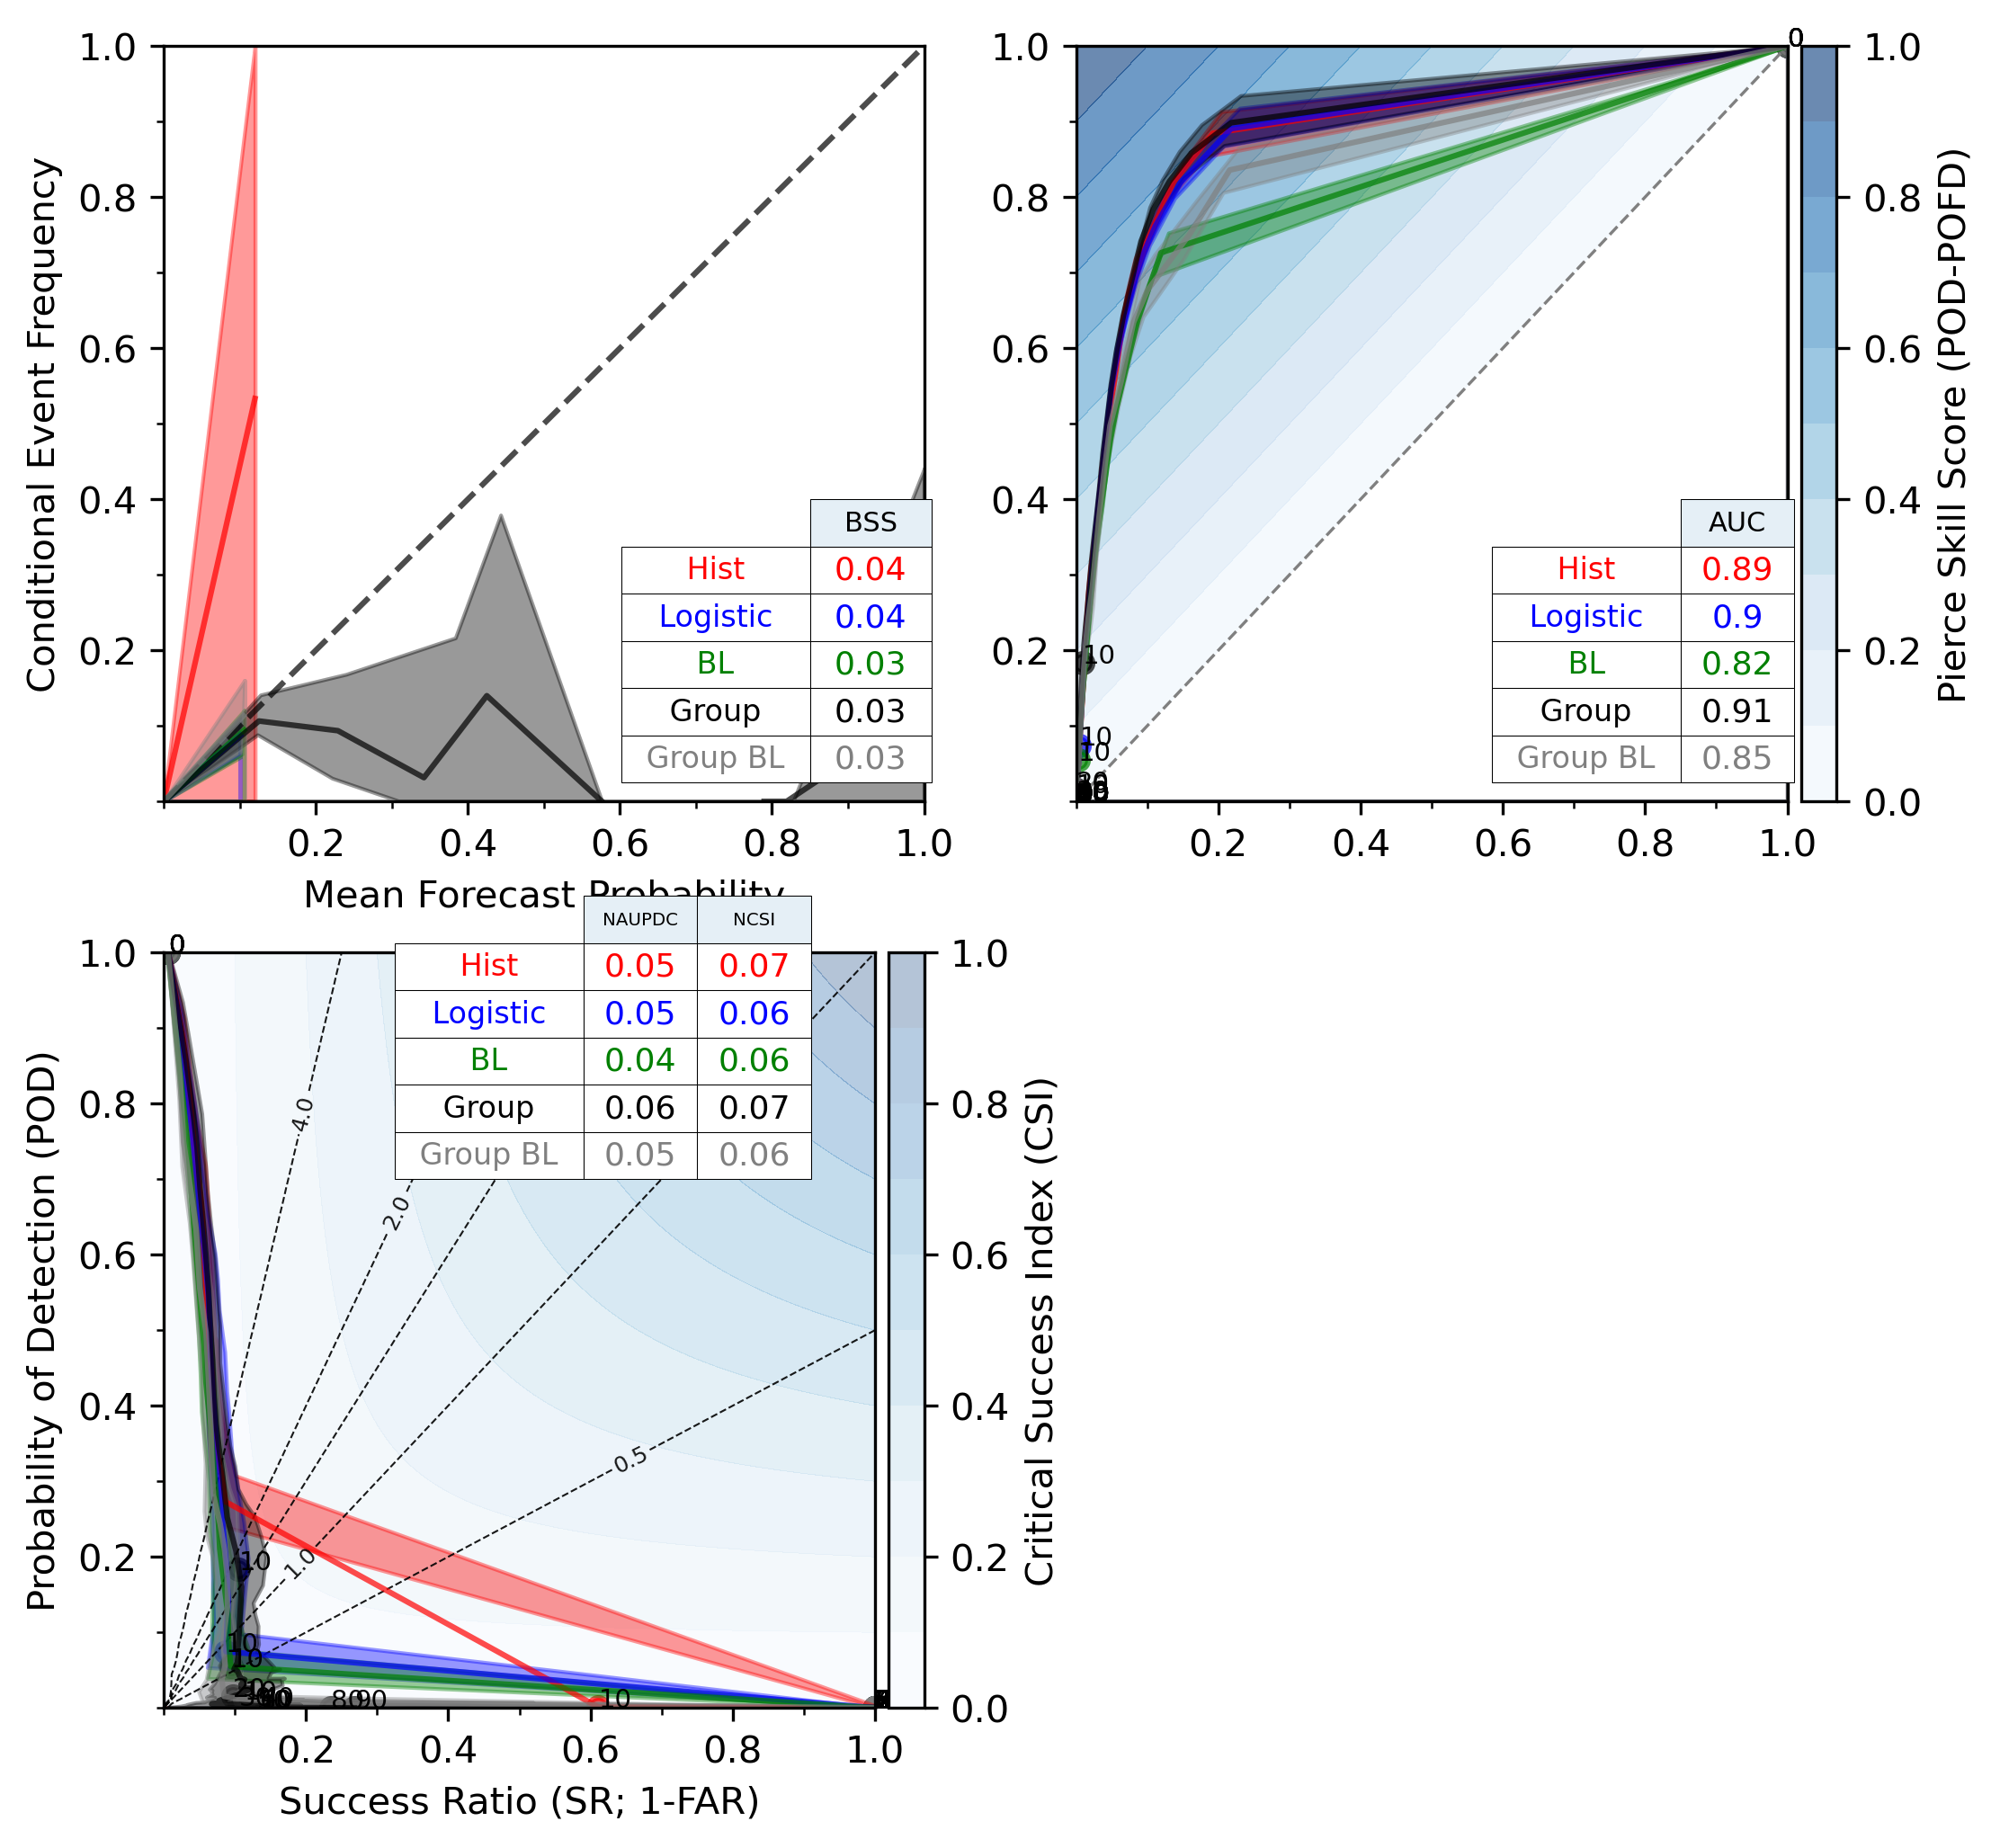

In [62]:
# Since X_bl and y are dataframe, we convert them to numpy.arrays 
# by using .values method. 
#plot_verification(estimators = estimators, 
#                  baseline_estimators = [('BL', bl_model)], 
#                  X = X, 
#                  X_baseline = X_bl.values, 
#                  y=y.values,
#                  n_boot=10,
#                  row_colors=['r','b','orange','k']#'r','b','g','orange','purple','k']
#                 )

plot_verification(y_true=y.values, y_pred=y_hat, names=[est[0] for est in estimators],
                      n_boot=30, style='classification', groups=groups)

# Uncomment and modify the filename to save the figure. 
#plt.savefig(f'{target_col}.png')


In [63]:
print(np.mean(y)*100)

0.5965880613472333


In [64]:
#dir(estimators[4][1])
#print(estimators[4][1].est_names)
#print(estimators[4][1].weights_)